# Загрузка данных

In [1]:
import numpy as np
import pandas as pd 
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ml-2025-spring-unsupervised/ml-2025-spring-unsupervised/sample_submission.csv
/kaggle/input/ml-2025-spring-unsupervised/ml-2025-spring-unsupervised/train.npz


In [2]:
from scipy import sparse
train = sparse.load_npz("/kaggle/input/ml-2025-spring-unsupervised/ml-2025-spring-unsupervised/train.npz")

# KMeans

## Предобработка данных для KMeans

In [3]:
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD

normalizer = Normalizer()
train_norm = normalizer.fit_transform(train)

n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
train_kmeans = svd.fit_transform(train_norm)

## Оценка К 

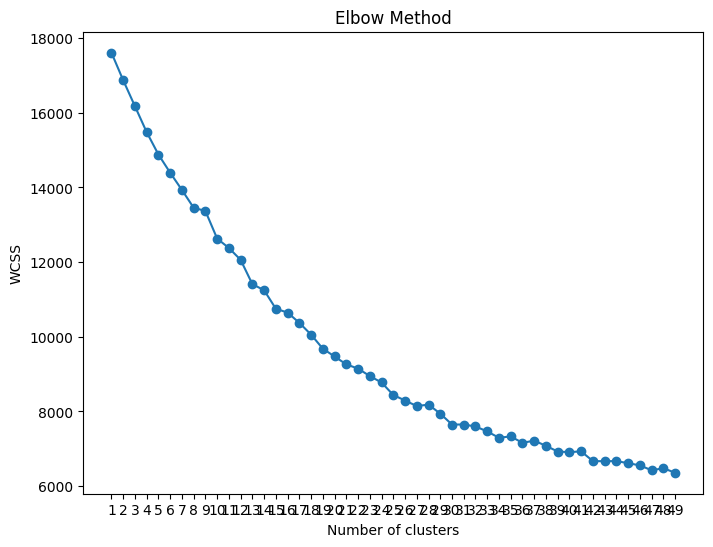

In [13]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []

for k in range(1, 50):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(train_kmeans)
    wcss.append(kmeans.inertia_)

# Строим график метода локтя
plt.figure(figsize=(8, 6))
plt.plot(range(1, 50), wcss, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.xticks(range(1, 50))
plt.show()

## Тренировка моделей

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_kmeans(train_reduced, n_clusters_list):
    results = {}
    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
        labels = kmeans.fit_predict(train_reduced)

        silhouette = silhouette_score(train_reduced, labels)
        calinski = calinski_harabasz_score(train_reduced, labels)
        davies = davies_bouldin_score(train_reduced, labels)

        results[n_clusters] = {'Silhouette': silhouette, 'Calinski': calinski, 'Davies': davies, 'labels': labels}
    return results

n_clusters_range = range(25, 31)
kmeans_results = evaluate_kmeans(train_kmeans, n_clusters_range)

for n_clusters, metrics in kmeans_results.items():
    print(f"Clusters: {n_clusters}, Silhouette: {metrics['Silhouette']:.4f}, Calinski: {metrics['Calinski']:.4f}, Davies: {metrics['Davies']:.4f}")

Clusters: 25, Silhouette: 0.3130, Calinski: 949.1319, Davies: 1.4511
Clusters: 26, Silhouette: 0.2892, Calinski: 942.5683, Davies: 1.8109
Clusters: 27, Silhouette: 0.3155, Calinski: 937.3590, Davies: 1.3974
Clusters: 28, Silhouette: 0.3124, Calinski: 894.8188, Davies: 1.3912
Clusters: 29, Silhouette: 0.2982, Calinski: 911.6095, Davies: 1.8261
Clusters: 30, Silhouette: 0.3074, Calinski: 941.4478, Davies: 1.7780


## Визуализация результатов KMeans

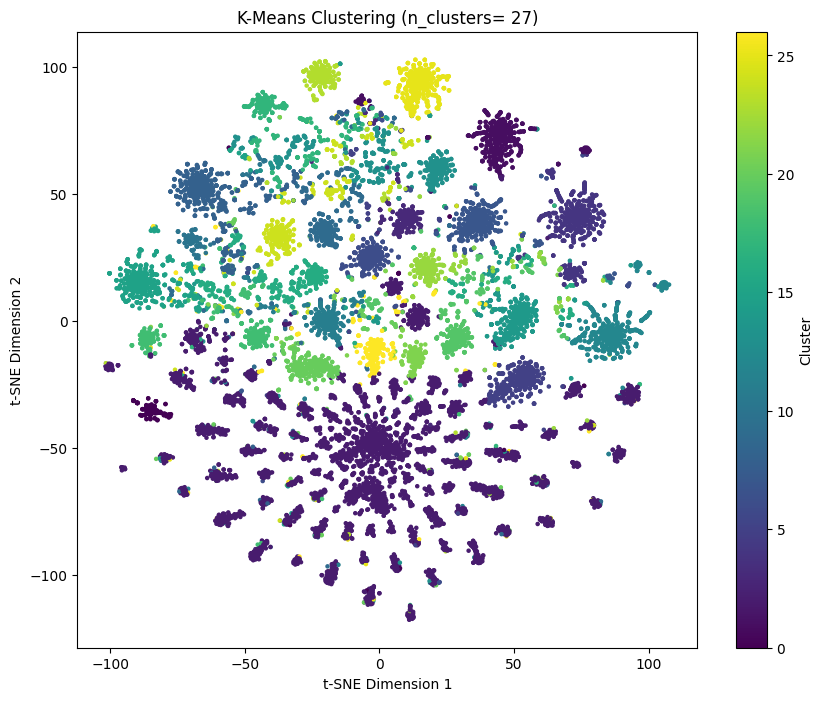

In [17]:
from sklearn.manifold import TSNE 

best_labels = kmeans_results[27]['labels']

# Снижаем размерность до 2D для визуализации
tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_kmeans)

plt.figure(figsize=(10, 8))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=best_labels, cmap='viridis', s=5)
plt.title(f"K-Means Clustering (n_clusters = 27)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

## Создание файла submission_kmeans_100_27.csv 

In [ ]:
kmeans = KMeans(n_clusters=27, n_init=10, random_state=42)
kmeans.fit(train_kmeans)
labels = kmeans.labels_

submission = pd.DataFrame({'ID': range(len(labels)), 'TARGET': labels})
submission.to_csv('submission_kmeans_100_27.csv', index=False)

# Gaussian Mixture

## Тренировка модели n_components = 100

In [4]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=27, random_state=42)
labels_gmm_100 = gmm.fit_predict(train_kmeans)

In [5]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette = silhouette_score(train_kmeans, labels_gmm_100)
calinski = calinski_harabasz_score(train_kmeans, labels_gmm_100)
davies = davies_bouldin_score(train_kmeans, labels_gmm_100)
bic = gmm.bic(train_kmeans)
aic = gmm.aic(train_kmeans)
        
print(
    f"Clusters: 27, "
    f"Silhouette: {silhouette:.4f}, "
    f"Calinski: {calinski:.4f}, "
    f"Davies: {davies:.4f}, "
    f"BIC: {bic:.2f}, "
    f"AIC: {aic:.2f}"
)

Clusters: 27, Silhouette: -0.0669, Calinski: 160.6779, Davies: 5.7428, BIC: -14794151.08, AIC: -15900122.05


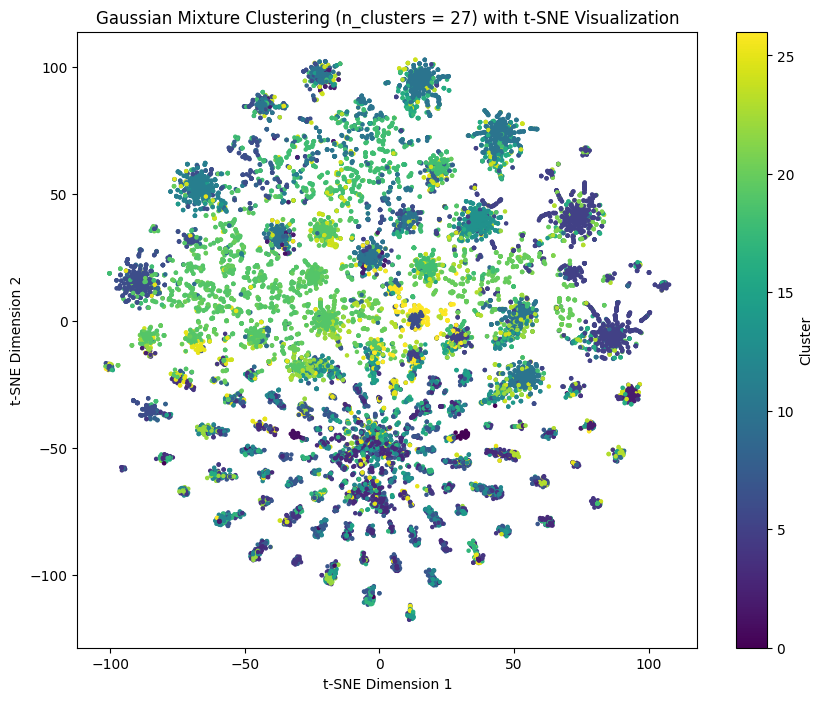

In [20]:
best_labels = labels

# Снижаем размерность до 2D для визуализации
tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_kmeans)

plt.figure(figsize=(10, 8))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=best_labels, cmap='viridis', s=5)
plt.title(f"Gaussian Mixture Clustering (n_clusters = 27) with t-SNE Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

## Создание файла submission_gmm_100_27.csv

In [ ]:
gmm = GaussianMixture(n_components=27, random_state=42)
labels = gmm.fit_predict(train_kmeans)

submission = pd.DataFrame({'ID': range(len(labels)), 'TARGET': labels})
submission.to_csv('submission_gmm_100_27.csv', index=False)

## Предобработка данных Gaussian Mixture (n_components = 200)

In [6]:
svd = TruncatedSVD(n_components=200, random_state=42)
train_gmm = svd.fit_transform(train_norm)

In [30]:
n_components_range = range(1, 50)
bic = []
aic = []
log_likelihood = []

for n_components in range(1, 50):
    gmm = GaussianMixture(n_components=200, random_state=42)
    gmm.fit(train_gmm)
    bic.append(gmm.bic(train_gmm))
    aic.append(gmm.aic(train_gmm))
    log_likelihood.append(-gmm.score(train_gmm))

# График BIC/AIC
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 50), bic, marker='o', label='BIC')
plt.plot(range(1, 50), aic, marker='o', label='AIC')
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.legend()
plt.title("BIC/AIC for GMM")

# График отрицательного правдоподобия (+- метода локтя)
plt.subplot(1, 2, 2)
plt.plot(range(1, 50), log_likelihood, marker='o', color='red')
plt.xlabel("Number of clusters")
plt.ylabel("Negative Log-Likelihood")
plt.title("GMM Elbow Method (Log-Likelihood)")
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

## Тренировка моделей n_components = 200

In [7]:
def evaluate_gmm(train, n_clusters_list, covariance_type='full', random_state=42):
    results = {}
    for n_clusters in n_clusters_list:
        gmm = GaussianMixture(
            n_components=n_clusters,
            covariance_type=covariance_type,
            random_state=random_state
        )
        labels = gmm.fit_predict(train)  

        silhouette = silhouette_score(train, labels)
        calinski = calinski_harabasz_score(train, labels)
        davies = davies_bouldin_score(train, labels)
        bic = gmm.bic(train)
        aic = gmm.aic(train)
        
        print(
            f"Clusters: {n_clusters}, "
            f"Silhouette: {silhouette:.4f}, "
            f"Calinski: {calinski:.4f}, "
            f"Davies: {davies:.4f}, "
            f"BIC: {bic:.2f}, "
            f"AIC: {aic:.2f}"
        )
        
        results[n_clusters] = {
            'Silhouette': silhouette,
            'Calinski': calinski,
            'Davies': davies,
            'labels': labels,
            'BIC': bic,
            'AIC': aic
        }
    return results

gmm_results = evaluate_gmm(train_gmm, range(24, 33))

Clusters: 24, Silhouette: -0.0581, Calinski: 189.9001, Davies: 3.5203, BIC: -28336873.16, AIC: -32211405.77
Clusters: 25, Silhouette: -0.0795, Calinski: 168.0485, Davies: 3.4972, BIC: -28339005.29, AIC: -32374977.08
Clusters: 26, Silhouette: -0.0551, Calinski: 193.7278, Davies: 3.4629, BIC: -28155476.83, AIC: -32352887.82
Clusters: 27, Silhouette: -0.0795, Calinski: 161.2615, Davies: 3.5250, BIC: -28274605.29, AIC: -32633455.47
Clusters: 28, Silhouette: -0.0869, Calinski: 161.2250, Davies: 3.3337, BIC: -28151297.20, AIC: -32671586.57
Clusters: 29, Silhouette: -0.0855, Calinski: 160.7692, Davies: 3.3055, BIC: -27847482.90, AIC: -32529211.45
Clusters: 30, Silhouette: -0.0993, Calinski: 160.1427, Davies: 3.1591, BIC: -27671144.64, AIC: -32514312.39
Clusters: 31, Silhouette: -0.1065, Calinski: 159.5996, Davies: 2.9766, BIC: -27553086.38, AIC: -32557693.32
Clusters: 32, Silhouette: -0.0991, Calinski: 152.7423, Davies: 3.1399, BIC: -27433783.02, AIC: -32599829.14


## Создание файлов submission_gmm_200_26.csv и submission_gmm_200_27.csv

In [ ]:
best_labels_gmm_200 = gmm_results[26]['labels']
submission = pd.DataFrame({'ID': range(len(best_labels_gmm_200)), 'TARGET': best_labels_gmm_200})
submission.to_csv('submission_gmm_200_26.csv', index=False)

In [9]:
best_labels_gmm_200 = gmm_results[27]['labels']
submission = pd.DataFrame({'ID': range(len(best_labels_gmm_200)), 'TARGET': best_labels_gmm_200})
submission.to_csv('submission_gmm_200_27.csv', index=False)

# DBSCAN

## Предобработка данных для DBSCAN

In [ ]:
n_components = 50
svd = TruncatedSVD(n_components=n_components, random_state=42)
train_dbscan = svd.fit_transform(train_norm)

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(train_kmeans) 

# Визуализация DBSCAN
tsne = TSNE(n_components=2, random_state=42)
train_tsne = tsne.fit_transform(train_kmeans)

plt.figure(figsize=(10, 8))
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=db_labels, cmap='viridis', s=5)
plt.title("DBSCAN Clustering with t-SNE Visualization")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label="Cluster")
plt.show()

## Подбор параметров 

In [ ]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(train_)
distances, indices = neighbors_fit.kneighbors(train_dbscan)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

## Тренировка моделей 

In [ ]:
from sklearn.cluster import DBSCAN

def evaluate_dbscan(train_reduced, eps_list, min_samples_list):
    results = {}
    for eps in eps_list:
        for min_samples in min_samples_list:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(train_reduced)

            if len(set(labels)) > 1:
                silhouette = silhouette_score(train_reduced, labels)
                calinski = calinski_harabasz_score(train_reduced, labels)
                davies = davies_bouldin_score(train_reduced, labels)
            else:
                silhouette = -1
                calinski = -1
                davies = -1

            results[(eps, min_samples)] = {'Silhouette': silhouette, 'Calinski': calinski, 'Davies': davies, 'Labels': labels}
    return results

eps_range = [0.1, 0.5, 1.0]
min_samples_range = [5, 10, 20]
dbscan_results = evaluate_dbscan(train_reduced, eps_range, min_samples_range)

for (eps, min_samples), metrics in dbscan_results.items():
    print(f"Eps: {eps}, Min Samples: {min_samples}, Silhouette: {metrics['Silhouette']:.4f}, Calinski: {metrics['Calinski']:.4f}, Davies: {metrics['Davies']:.4f}")


## Создание файла submission_dbscan_50.csv

In [ ]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(train_reduced)

submission.to_csv('submission_dbscan_50.csv', index=False)